# Efficient Keyword Spotting for LED Control with TensorFlow Lite for Microcontrollers

This notebook is part of a project to develop an efficient audio keyword spotting system capable of recognizing simple voice commands (e.g., "on", "off", "one", "two", "three") to control an RGB LED. The model is designed and optimized for deployment on resource-constrained microcontrollers (MCUs) using TensorFlow Lite for Microcontrollers (TFLM).

Full project available on [GitHub](https://github.com/anacletu/tflm-keyword-spotting-led)

## Dataset Exploration

In [1]:
# Importing the relevant libraries
import tensorflow as tf
import tensorflow_datasets as tfds
import librosa
from functools import partial
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
import sounddevice as sd

# Checking TensorFlow and GPU availability
print("TensorFlow Version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow Version: 2.16.2
Num GPUs Available:  1


In [47]:
# Global variables

N_MFCC = 13  # Number of MFCCs to return
N_FFT = 2048 # Length of the FFT window
HOP_LENGTH = 512 # Number of samples between successive frames
SAMPLE_RATE = 16000 # Sample rate for audio files
BATCH_SIZE = 64 # Batch size for training
TARGET_FRAMES = 32 # Number of frames to target for each audio sample

### Helper Functions

In [18]:
def filter_and_label_example(example_audio, example_label_int):
    """
    Processes audio for model input. Model learns all dataset labels, the input label is passed through as the model label.

    Args:
        example_audio: The audio tensor from the dataset.
        example_label_int: The integer label tensor from the dataset (0-11 for v0.0.3).

    Returns:
        A tuple (processed_audio_tensor, model_label_int_tensor)
    """
    # Handle audio type and normalization
    def numpy_fn(audio_tensor_arg, label_tensor_arg):
        # Convert EagerTensors to NumPy arrays
        audio_np = audio_tensor_arg.numpy()
        label_np = label_tensor_arg.numpy()
        
        if audio_np.dtype == np.int16:
            audio_processed_np = audio_np.astype(np.float32) / 32768.0 # Normalize int16 to float32 range
        elif audio_np.dtype != np.float32:
            audio_processed_np = audio_np.astype(np.float32)
        else:
            audio_processed_np = audio_np # Already float32

        model_label_int = label_np

        return audio_processed_np, np.int64(model_label_int)

    audio, label = tf.py_function(
        func=numpy_fn,
        inp=[example_audio, example_label_int],
        Tout=(tf.float32, example_label_int.dtype)
    )
    audio.set_shape(example_audio.shape)
    
    # Ensure label output shape is scalar if example_label_int is scalar
    if example_label_int.shape == tf.TensorShape([]):
        label.set_shape([])
    else:
        label.set_shape(example_label_int.shape)
        
    return audio, label

In [24]:
def map_fn_train(example, label_key):
    """
    Mapping function to be used with tf.data.Dataset.map().
    Extracts audio and label from the example, and passes them to filter_and_label_example.

    Args:
        example: Dictionary with 'audio' and label tensor.
        label_key: Key used to access the label in the dataset (typically 'label').
        config: Configuration dictionary containing class mappings and keywords.

    Returns:
        A tuple (audio_tensor, model_label_int)
    """
    audio = example['audio']
    label = example[label_key]
    return filter_and_label_example(audio, label)


In [50]:
def extract_mfccs_tf_py_function(audio_tensor, label_tensor):
    def numpy_mfcc_extractor(audio_tensor_arg, label_tensor_arg):
        # Convert input EagerTensors to NumPy arrays FIRST
        audio_np_for_mfcc = audio_tensor_arg.numpy()
        label_np_for_passthrough = label_tensor_arg.numpy()

        # audio_np_for_mfcc is already float32 normalized from the previous step
        mfccs = librosa.feature.mfcc(y=audio_np_for_mfcc,
                                     sr=SAMPLE_RATE,
                                     n_mfcc=N_MFCC,
                                     n_fft=N_FFT,
                                     hop_length=HOP_LENGTH)
        
        # Adding padding/truncation to ensure consistent output shape
        if mfccs.shape[1] < TARGET_FRAMES:
            # Pad if too short
            padding_width = TARGET_FRAMES - mfccs.shape[1]
            mfccs_padded = np.pad(mfccs, ((0, 0), (0, padding_width)), mode='constant', constant_values=0)
        elif mfccs.shape[1] > TARGET_FRAMES:
            # Truncate if too long
            mfccs_padded = mfccs[:, :TARGET_FRAMES]
        else:
            # Already correct length
            mfccs_padded = mfccs

        return mfccs_padded.astype(np.float32), label_np_for_passthrough # Ensure MFCCs are float32
        
    num_frames_calculated = int(np.ceil(float(16000) / HOP_LENGTH)) # Example for 16000 samples, 16kHz, hop 512 -> 32 frames

    mfcc_output_shape = (N_MFCC, num_frames_calculated)

    mfccs_tensor, label_passthrough_tensor = tf.py_function(
        func=numpy_mfcc_extractor,
        inp=[audio_tensor, label_tensor],
        Tout=(tf.float32, label_tensor.dtype) # MFCCs are float32, label dtype passes through
    )

    # Set the shape for the MFCC tensor
    mfccs_tensor.set_shape(mfcc_output_shape)
    # Set the shape for the label tensor (should be scalar)
    if label_tensor.shape == tf.TensorShape([]):
        label_passthrough_tensor.set_shape([])
    else:
        label_passthrough_tensor.set_shape(label_tensor.shape)

    return mfccs_tensor, label_passthrough_tensor

### 1. Loading and Preparing

In [16]:
# Loading the speech_commands dataset (version 0.0.3) from TensorFlow Datasets
# This version contains 12 classes, including 'unknown' and 'silence'.
# The dataset is split into training, validation, and test sets.

# Defining the path for the dataset
DATA_PATH = os.path.join("..", "data", "raw", "tensorflow_datasets")
os.makedirs(DATA_PATH, exist_ok=True)

try:
    builder = tfds.builder("speech_commands:0.0.3")
    builder.download_and_prepare(download_dir=DATA_PATH)
    ds_train_full, ds_info = tfds.load('speech_commands', split='train', with_info=True, shuffle_files=True, data_dir=DATA_PATH)
    ds_val_full = tfds.load('speech_commands', split='validation', shuffle_files=False, data_dir=DATA_PATH)
    ds_test_full = tfds.load('speech_commands', split='test', shuffle_files=False, data_dir=DATA_PATH)

except Exception as e:
    print(f"Error loading dataset: {e}")
    raise e # Stop execution if dataset loading fails

# Displaying the dataset information if successfully loaded
print("\nDataset Information (ds_info):")
print(ds_info)


Dataset Information (ds_info):
tfds.core.DatasetInfo(
    name='speech_commands',
    full_name='speech_commands/0.0.3',
    description="""
    An audio dataset of spoken words designed to help train and evaluate keyword
    spotting systems. Its primary goal is to provide a way to build and test small
    models that detect when a single word is spoken, from a set of ten target words,
    with as few false positives as possible from background noise or unrelated
    speech. Note that in the train and validation set, the label "unknown" is much
    more prevalent than the labels of the target words or background noise. One
    difference from the release version is the handling of silent segments. While in
    the test set the silence segments are regular 1 second files, in the training
    they are provided as long segments under "background_noise" folder. Here we
    split these background noise into 1 second clips, and also keep one of the files
    for the validation set.
    """

In [31]:
# Checking the features in the dataset
print("\nFeatures:")
print(ds_info.features)

# Label key for the dataset
label_key = 'label'

# Classes in the dataset
num_total_classes = ds_info.features[label_key].num_classes
print(f"\nTotal number of classes in the dataset: {num_total_classes}")

# String names of the classes
class_names_full = ds_info.features[label_key].names
print(f"\nFull list of class names:")
print(class_names_full)

# Number of examples in each split
print(f"\nNumber of examples in train split: {ds_info.splits['train'].num_examples}")
print(f"Number of examples in validation split: {ds_info.splits['validation'].num_examples}")
print(f"Number of examples in test split: {ds_info.splits['test'].num_examples}")

# Audio sample rate
SAMPLE_RATE = ds_info.features['audio'].sample_rate
print(f"\nSample rate: {SAMPLE_RATE} Hz")


Features:
FeaturesDict({
    'audio': Audio(shape=(None,), dtype=int16),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=12),
})

Total number of classes in the dataset: 12

Full list of class names:
['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes', '_silence_', '_unknown_']

Number of examples in train split: 85511
Number of examples in validation split: 10102
Number of examples in test split: 4890

Sample rate: 16000 Hz


In [7]:
print(ds_info)

tfds.core.DatasetInfo(
    name='speech_commands',
    full_name='speech_commands/0.0.3',
    description="""
    An audio dataset of spoken words designed to help train and evaluate keyword
    spotting systems. Its primary goal is to provide a way to build and test small
    models that detect when a single word is spoken, from a set of ten target words,
    with as few false positives as possible from background noise or unrelated
    speech. Note that in the train and validation set, the label "unknown" is much
    more prevalent than the labels of the target words or background noise. One
    difference from the release version is the handling of silent segments. While in
    the test set the silence segments are regular 1 second files, in the training
    they are provided as long segments under "background_noise" folder. Here we
    split these background noise into 1 second clips, and also keep one of the files
    for the validation set.
    """,
    homepage='https://arxiv.or


--- Single Example ---
Audio data shape: (16000,)
Audio data type: int16
Min audio value: -32606, Max audio value: 32561
Integer label: 11
String label: _unknown_


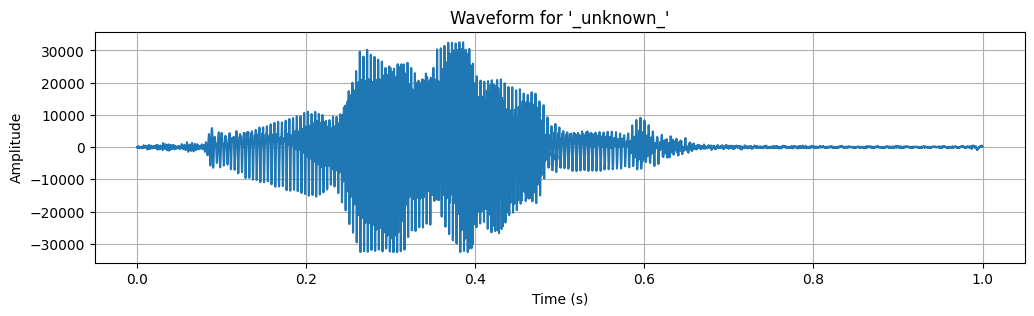

Playing audio for '_unknown_'...
Playback finished.

MFCCs shape: (13, 32)


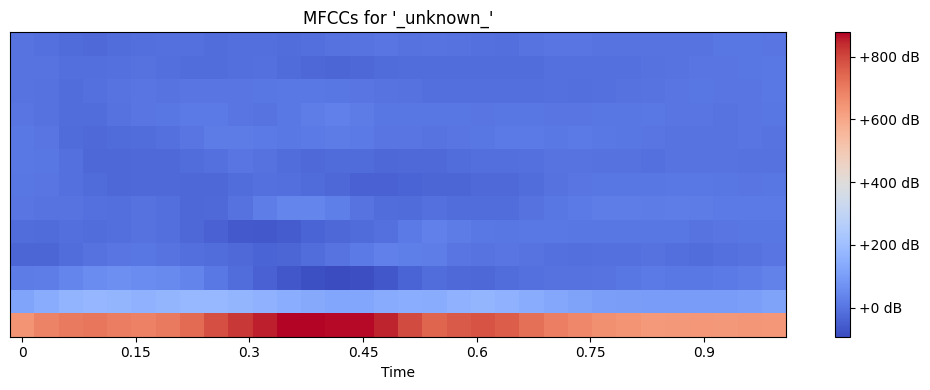

2025-06-03 20:20:28.065886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [32]:
# Checking one random example from the training dataset for visualization
for example in ds_train_full.take(1):
    audio_data = example['audio'].numpy()
    label_int = example[label_key].numpy()
    label_str = class_names_full[label_int]

    print(f"\n--- Single Example ---")
    print(f"Audio data shape: {audio_data.shape}") 
    print(f"Audio data type: {audio_data.dtype}")
    print(f"Min audio value: {np.min(audio_data)}, Max audio value: {np.max(audio_data)}")
    print(f"Integer label: {label_int}")
    print(f"String label: {label_str}")

    # Visualizing the waveform
    plt.figure(figsize=(12, 3))
    plt.plot(np.linspace(0, len(audio_data) / SAMPLE_RATE, num=len(audio_data)), audio_data)
    plt.title(f"Waveform for '{label_str}'")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

    # Play the audio
    try:
        print(f"Playing audio for '{label_str}'...")
        sd.play(audio_data, SAMPLE_RATE)
        sd.wait()
        print("Playback finished.")
    except Exception as e:
        print(f"Could not play audio: {e}. Ensure sounddevice is installed and working.")
    
    # Ensure audio_data is float for librosa
    mfccs = librosa.feature.mfcc(y=audio_data.astype(float),
                                 sr=SAMPLE_RATE,
                                 n_mfcc=N_MFCC,
                                 n_fft=N_FFT,
                                 hop_length=HOP_LENGTH)

    print(f"\nMFCCs shape: {mfccs.shape}") # (n_mfcc, n_frames)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, sr=SAMPLE_RATE, hop_length=HOP_LENGTH, x_axis='time')
    plt.colorbar(format='%+2.0f dB') # Colorbar shows decibels
    plt.title(f"MFCCs for '{label_str}'")
    plt.tight_layout()
    plt.show()

In [52]:
# 1. Define the labels the MODEL will learn and predict.
config = {}
config["all_model_labels"] = class_names_full
print(f"All labels the model will learn (all_model_labels): {config['all_model_labels']}")
print(f"Number of classes model will predict: {len(config['all_model_labels'])}") 

# 2. Create mappings for these model labels
config["label_to_int"] = {label: i for i, label in enumerate(config["all_model_labels"])}
config["int_to_label"] = {i: label for i, label in enumerate(config["all_model_labels"])} 
print(f"\nLabel to int mapping for model: {config['label_to_int']}")
print(f"Int to label mapping for model: {config['int_to_label']}")


# 3. Define the application-specific target keywords for LED control (just for reference).
config["target_keywords"] = ["up", "down", "left", "on", "off"] # 
print(f"\nApplication target keywords for LED control: {config['target_keywords']}")

All labels the model will learn (all_model_labels): ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes', '_silence_', '_unknown_']
Number of classes model will predict: 12

Label to int mapping for model: {'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'up': 8, 'yes': 9, '_silence_': 10, '_unknown_': 11}
Int to label mapping for model: {0: 'down', 1: 'go', 2: 'left', 3: 'no', 4: 'off', 5: 'on', 6: 'right', 7: 'stop', 8: 'up', 9: 'yes', 10: '_silence_', 11: '_unknown_'}

Application target keywords for LED control: ['up', 'down', 'left', 'on', 'off']


### Testing the Helper Functions

In [53]:
# Test Case 1: A word that is one of the 10 core commands
test_word_core_command = "on"
n_iterations = 2000 # Iterate enough to find it

print(f"\n--- Testing with a core command: '{test_word_core_command}' ---")
found_core_command = False
for ex in ds_train_full.take(n_iterations): 
    # Get the original string label from the dataset
    original_dataset_label_str = class_names_full[ex[label_key].numpy()]

    if original_dataset_label_str == test_word_core_command:
        processed_audio_tensor, processed_label_int_tensor = filter_and_label_example(
            ex['audio'], ex[label_key]
        )

        processed_label_int = processed_label_int_tensor.numpy()

        print(f"Original dataset label string: '{original_dataset_label_str}'")
        print(f"Original dataset label int: {ex[label_key].numpy()}")
        print(f"Processed model label int: {processed_label_int}")
        print(f"Processed model label string (from config['int_to_label']): {config['int_to_label'][processed_label_int]}")
        found_core_command = True
        break

if not found_core_command:
    print(f"Could not find an example of '{test_word_core_command}' in the first {n_iterations} samples of ds_train_full.")



--- Testing with a core command: 'on' ---
Original dataset label string: 'on'
Original dataset label int: 5
Processed model label int: 5
Processed model label string (from config['int_to_label']): on


In [20]:
# Test Case 2: An example that TFDS v0.0.3 labels as '_unknown_'
test_dataset_label_is_unknown = "_unknown_" 

print(f"\n--- Testing with an example labeled as '{test_dataset_label_is_unknown}' by the dataset ---")
found_unknown_example = False
for ex in ds_train_full.take(n_iterations): 
    original_dataset_label_str = class_names_full[ex[label_key].numpy()]

    if original_dataset_label_str == test_dataset_label_is_unknown:
        processed_audio_tensor, processed_label_int_tensor = filter_and_label_example(
            ex['audio'], ex[label_key]
        )
        processed_label_int = processed_label_int_tensor.numpy()

        print(f"Original dataset label string: '{original_dataset_label_str}'")
        print(f"Original dataset label int: {ex[label_key].numpy()}") # Should be index of '_unknown_'
        print(f"Processed model label int: {processed_label_int}")   # Should be the same index
        print(f"Processed model label string (from config['int_to_label']): {config['int_to_label'][processed_label_int]}")
        found_unknown_example = True
        break
if not found_unknown_example:
    print(f"Could not find an example labeled as '{test_dataset_label_is_unknown}' in the first {n_iterations} samples of ds_train_full.")


--- Testing with an example labeled as '_unknown_' by the dataset ---
Original dataset label string: '_unknown_'
Original dataset label int: 11
Processed model label int: 11
Processed model label string (from config['int_to_label']): _unknown_


In [21]:
# Test Case 3: An example labeled as '_silence_' by the dataset
test_dataset_label_is_silence = "_silence_"

print(f"\n--- Testing with an example labeled as '{test_dataset_label_is_silence}' by the dataset ---")
found_silence_example = False
for ex in ds_train_full.take(n_iterations): 
    original_dataset_label_str = class_names_full[ex[label_key].numpy()]

    if original_dataset_label_str == test_dataset_label_is_silence:
        processed_audio_tensor, processed_label_int_tensor = filter_and_label_example(
            ex['audio'], ex[label_key]
        )
        processed_label_int = processed_label_int_tensor.numpy()

        print(f"Original dataset label string: '{original_dataset_label_str}'")
        print(f"Original dataset label int: {ex[label_key].numpy()}")
        print(f"Processed model label int: {processed_label_int}")
        print(f"Processed model label string (from config['int_to_label']): {config['int_to_label'][processed_label_int]}")
        found_silence_example = True
        break
if not found_silence_example:
    print(f"Could not find an example labeled as '{test_dataset_label_is_silence}' in the first {n_iterations} samples of ds_train_full.")


--- Testing with an example labeled as '_silence_' by the dataset ---
Original dataset label string: '_silence_'
Original dataset label int: 10
Processed model label int: 10
Processed model label string (from config['int_to_label']): _silence_


In [54]:
# Wrap the map function with predefined arguments
map_fn = partial(map_fn_train, label_key=label_key)

# Apply the mapping
ds_train_mapped = ds_train_full.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE)
ds_val_mapped = ds_val_full.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE)
ds_test_mapped = ds_test_full.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE)

## Feature Extraction (MFCCs) and Final Dataset Preparation

### MFCC Feature Extraction


--- Testing MFCC Extraction ---
Original audio shape: (16000,), Original label: 11
MFCC features shape: (13, 32)
Label after MFCC: 11


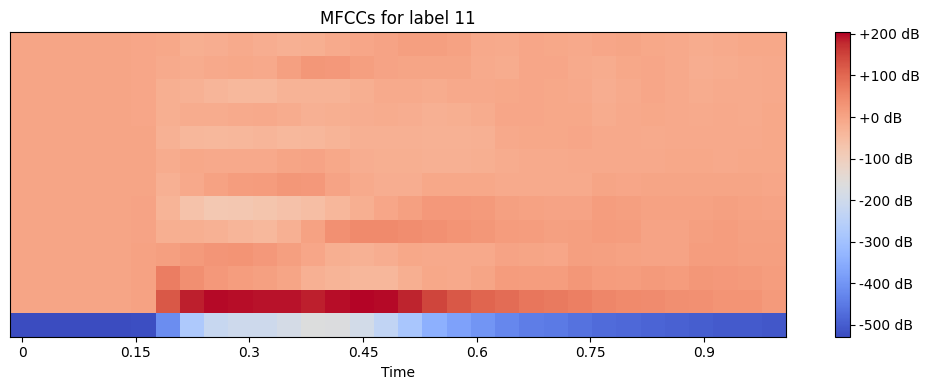

In [55]:
# Testing the MFCC extraction function
print("\n--- Testing MFCC Extraction ---")
for audio_sample, label_sample in ds_train_mapped.take(1):
    print(f"Original audio shape: {audio_sample.shape}, Original label: {label_sample.numpy()}")
    mfcc_features, label_after_mfcc = extract_mfccs_tf_py_function(audio_sample, label_sample)
    print(f"MFCC features shape: {mfcc_features.shape}") # Should be (N_MFCC, num_frames_calculated)
    print(f"Label after MFCC: {label_after_mfcc.numpy()}")
    # Optional: Plot the MFCCs
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc_features.numpy(), # Convert to numpy for plotting
                             sr=SAMPLE_RATE,
                             hop_length=HOP_LENGTH,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"MFCCs for label {label_after_mfcc.numpy()}")
    plt.tight_layout()
    plt.show()
    break

In [56]:
# Applying the MFCC extraction function to the datasets
ds_train_features = ds_train_mapped.map(extract_mfccs_tf_py_function, num_parallel_calls=tf.data.AUTOTUNE)
ds_val_features = ds_val_mapped.map(extract_mfccs_tf_py_function, num_parallel_calls=tf.data.AUTOTUNE)
ds_test_features = ds_test_mapped.map(extract_mfccs_tf_py_function, num_parallel_calls=tf.data.AUTOTUNE)

# Check the first element of the new dataset
print("\n--- First example from dataset with MFCC features ---")
for mfcc_ex, label_ex in ds_train_features.take(1):
    print(f"MFCC example shape: {mfcc_ex.shape}, Label: {label_ex.numpy()}")


--- First example from dataset with MFCC features ---
MFCC example shape: (13, 32), Label: 11


2025-06-03 20:47:01.049525: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Cache, Shuffle, and Batch the Datasets


In [57]:
# Prepare the TRAINING dataset
print("Preparing ds_train...")
ds_train_intermediate = ds_train_features.cache()

# Calculate the number of elements in the training dataset for the shuffle buffer
print("Calculating shuffle buffer size for ds_train...")
SHUFFLE_BUFFER_SIZE = 0
for _ in ds_train_intermediate:
    SHUFFLE_BUFFER_SIZE += 1
print(f"Calculated SHUFFLE_BUFFER_SIZE for ds_train: {SHUFFLE_BUFFER_SIZE}")

# Now apply shuffle, batch, prefetch
ds_train = ds_train_intermediate.shuffle(SHUFFLE_BUFFER_SIZE, reshuffle_each_iteration=True)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)
print("ds_train preparation complete.")


Preparing ds_train...
Calculating shuffle buffer size for ds_train...


2025-06-03 20:59:49.595115: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Calculated SHUFFLE_BUFFER_SIZE for ds_train: 85511
ds_train preparation complete.


2025-06-03 21:01:10.212751: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [58]:
# Prepare the VALIDATION dataset
print("\nPreparing ds_val...")
ds_val = ds_val_features.cache()
ds_val = ds_val.batch(BATCH_SIZE)
ds_val = ds_val.prefetch(tf.data.AUTOTUNE)
print("ds_val preparation complete.")


Preparing ds_val...
ds_val preparation complete.


In [59]:
# Prepare the TEST dataset
print("\nPreparing ds_test...")
ds_test = ds_test_features.cache()
ds_test = ds_test.batch(BATCH_SIZE)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)
print("ds_test preparation complete.")


Preparing ds_test...
ds_test preparation complete.


In [60]:
# Verify the output of one batch from the prepared training data
print("\n--- Shape of one batch from final processed training data (ds_train) ---")
for mfcc_batch, label_batch in ds_train.take(1):
    print(f"MFCC batch shape: {mfcc_batch.shape}")
    print(f"Label batch shape: {label_batch.shape}")
    print(f"Data type of MFCC batch: {mfcc_batch.dtype}")
    print(f"Data type of Label batch: {label_batch.dtype}")
    break

print("\n--- Shape of one batch from final processed validation data (ds_val) ---")
for mfcc_batch_val, label_batch_val in ds_val.take(1):
    print(f"MFCC batch shape (validation): {mfcc_batch_val.shape}")
    print(f"Label batch shape (validation): {label_batch_val.shape}")
    break

print("\nDataset preparation complete for training, validation, and testing!")


--- Shape of one batch from final processed training data (ds_train) ---
MFCC batch shape: (64, 13, 32)
Label batch shape: (64,)
Data type of MFCC batch: <dtype: 'float32'>
Data type of Label batch: <dtype: 'int64'>

--- Shape of one batch from final processed validation data (ds_val) ---
MFCC batch shape (validation): (64, 13, 32)
Label batch shape (validation): (64,)

Dataset preparation complete for training, validation, and testing!


2025-06-03 21:05:02.392115: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
